In [1]:
%matplotlib inline

`torchvision
models <https://pytorch.org/docs/stable/torchvision/models.html>`

**finetuning**, 

start with a pretrained model and update *all* of the model’s parameters for our new
task, in essence retraining the whole model. 

**feature extraction**,

start with a pretrained model and only update the final layer weights
from which we derive predictions. 

`<https://cs231n.github.io/transfer-learning/>`

`<https://ruder.io/transfer-learning/>`

both methods follow same steps:

-  Initialize the pretrained model
-  Reshape the final layer(s) to have the same number of outputs as the
   number of classes in the new dataset
-  Define for the optimization algorithm which parameters we want to
   update during training
-  Run the training step




In [2]:
from __future__ import print_function 
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.2.0
Torchvision Version:  0.4.0a0


Inputs
------

Here are all of the parameters to change for the run. We will use the
*hymenoptera_data* dataset which can be downloaded
`here <https://download.pytorch.org/tutorial/hymenoptera_data.zip>`__.
This dataset contains two classes, **bees** and **ants**, and is
structured such that we can use the
`ImageFolder <https://pytorch.org/docs/stable/torchvision/datasets.html#torchvision.datasets.ImageFolder>`__
dataset, rather than writing our own custom dataset. Download the data
and set the ``data_dir`` input to the root directory of the dataset. The
``model_name`` input is the name of the model you wish to use and must
be selected from this list:

::

   [resnet, alexnet, vgg, squeezenet, densenet, inception]

The other inputs are as follows: ``num_classes`` is the number of
classes in the dataset, ``batch_size`` is the batch size used for
training and may be adjusted according to the capability of your
machine, ``num_epochs`` is the number of training epochs we want to run,
and ``feature_extract`` is a boolean that defines if we are finetuning
or feature extracting. If ``feature_extract = False``, the model is
finetuned and all model parameters are updated. If
``feature_extract = True``, only the last layer parameters are updated,
the others remain fixed.




In [3]:
# Top level data directory. Here we assume the format of the directory conforms 
#   to the ImageFolder structure
data_dir = "./data/hymenoptera_data"

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "alexnet" #"squeezenet"

# Number of classes in the dataset
num_classes = 2

# Batch size for training (change depending on how much memory you have)
batch_size = 20

# Number of epochs to train for 
num_epochs = 5000

# Flag for feature extracting. When False, we finetune the whole model, 
#   when True we only update the reshaped layer params
feature_extract = True

Helper Functions
----------------

Before we write the code for adjusting the models, lets define a few
helper functions.

Model Training and Validation Code
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

The ``train_model`` function handles the training and validation of a
given model. As input, it takes a PyTorch model, a dictionary of
dataloaders, a loss function, an optimizer, a specified number of epochs
to train and validate for, and a boolean flag for when the model is an
Inception model. The *is_inception* flag is used to accomodate the
*Inception v3* model, as that architecture uses an auxiliary output and
the overall model loss respects both the auxiliary output and the final
output, as described
`here <https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958>`__.
The function trains for the specified number of epochs and after each
epoch runs a full validation step. It also keeps track of the best
performing model (in terms of validation accuracy), and at the end of
training returns the best performing model. After each epoch, the
training and validation accuracies are printed.




In [4]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        # -----------------------
        if epoch % 50 == 0:
            plt.plot(val_acc_history)
            plt.show()
            
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                print('inputs are:', inputs.shape)
                print('labels are:', labels.shape)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

Set Model Parameters’ .requires_grad attribute
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

This helper function sets the ``.requires_grad`` attribute of the
parameters in the model to False when we are feature extracting. By
default, when we load a pretrained model all of the parameters have
``.requires_grad=True``, which is fine if we are training from scratch
or finetuning. However, if we are feature extracting and only want to
compute gradients for the newly initialized layer then we want all of
the other parameters to not require gradients. This will make more sense
later.




In [7]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            # print("let's set param grad to false", param.shape)
            param.requires_grad = False

Initialize and Reshape the Networks
-----------------------------------

Now to the most interesting part. Here is where we handle the reshaping
of each network. Note, this is not an automatic procedure and is unique
to each model. Recall, the final layer of a CNN model, which is often
times an FC layer, has the same number of nodes as the number of output
classes in the dataset. Since all of the models have been pretrained on
Imagenet, they all have output layers of size 1000, one node for each
class. The goal here is to reshape the last layer to have the same
number of inputs as before, AND to have the same number of outputs as
the number of classes in the dataset. In the following sections we will
discuss how to alter the architecture of each model individually. But
first, there is one important detail regarding the difference between
finetuning and feature-extraction.

When feature extracting, we only want to update the parameters of the
last layer, or in other words, we only want to update the parameters for
the layer(s) we are reshaping. Therefore, we do not need to compute the
gradients of the parameters that we are not changing, so for efficiency
we set the .requires_grad attribute to False. This is important because
by default, this attribute is set to True. Then, when we initialize the
new layer and by default the new parameters have ``.requires_grad=True``
so only the new layer’s parameters will be updated. When we are
finetuning we can leave all of the .required_grad’s set to the default
of True.

Finally, notice that inception_v3 requires the input size to be
(299,299), whereas all of the other models expect (224,224).

Resnet
~~~~~~

Resnet was introduced in the paper `Deep Residual Learning for Image
Recognition <https://arxiv.org/abs/1512.03385>`__. There are several
variants of different sizes, including Resnet18, Resnet34, Resnet50,
Resnet101, and Resnet152, all of which are available from torchvision
models. Here we use Resnet18, as our dataset is small and only has two
classes. When we print the model, we see that the last layer is a fully
connected layer as shown below:

::

   (fc): Linear(in_features=512, out_features=1000, bias=True) 

Thus, we must reinitialize ``model.fc`` to be a Linear layer with 512
input features and 2 output features with:

::

   model.fc = nn.Linear(512, num_classes)

Alexnet
~~~~~~~

Alexnet was introduced in the paper `ImageNet Classification with Deep
Convolutional Neural
Networks <https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf>`__
and was the first very successful CNN on the ImageNet dataset. When we
print the model architecture, we see the model output comes from the 6th
layer of the classifier

::

   (classifier): Sequential(
       ...
       (6): Linear(in_features=4096, out_features=1000, bias=True)
    ) 

To use the model with our dataset we reinitialize this layer as

::

   model.classifier[6] = nn.Linear(4096,num_classes)

VGG
~~~

VGG was introduced in the paper `Very Deep Convolutional Networks for
Large-Scale Image Recognition <https://arxiv.org/pdf/1409.1556.pdf>`__.
Torchvision offers eight versions of VGG with various lengths and some
that have batch normalizations layers. Here we use VGG-11 with batch
normalization. The output layer is similar to Alexnet, i.e.

::

   (classifier): Sequential(
       ...
       (6): Linear(in_features=4096, out_features=1000, bias=True)
    )

Therefore, we use the same technique to modify the output layer

::

   model.classifier[6] = nn.Linear(4096,num_classes)

Squeezenet
~~~~~~~~~~

The Squeeznet architecture is described in the paper `SqueezeNet:
AlexNet-level accuracy with 50x fewer parameters and <0.5MB model
size <https://arxiv.org/abs/1602.07360>`__ and uses a different output
structure than any of the other models shown here. Torchvision has two
versions of Squeezenet, we use version 1.0. The output comes from a 1x1
convolutional layer which is the 1st layer of the classifier:

::

   (classifier): Sequential(
       (0): Dropout(p=0.5)
       (1): Conv2d(512, 1000, kernel_size=(1, 1), stride=(1, 1))
       (2): ReLU(inplace)
       (3): AvgPool2d(kernel_size=13, stride=1, padding=0)
    ) 

To modify the network, we reinitialize the Conv2d layer to have an
output feature map of depth 2 as

::

   model.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))

Densenet
~~~~~~~~

Densenet was introduced in the paper `Densely Connected Convolutional
Networks <https://arxiv.org/abs/1608.06993>`__. Torchvision has four
variants of Densenet but here we only use Densenet-121. The output layer
is a linear layer with 1024 input features:

::

   (classifier): Linear(in_features=1024, out_features=1000, bias=True) 

To reshape the network, we reinitialize the classifier’s linear layer as

::

   model.classifier = nn.Linear(1024, num_classes)

Inception v3
~~~~~~~~~~~~

Finally, Inception v3 was first described in `Rethinking the Inception
Architecture for Computer
Vision <https://arxiv.org/pdf/1512.00567v1.pdf>`__. This network is
unique because it has two output layers when training. The second output
is known as an auxiliary output and is contained in the AuxLogits part
of the network. The primary output is a linear layer at the end of the
network. Note, when testing we only consider the primary output. The
auxiliary output and primary output of the loaded model are printed as:

::

   (AuxLogits): InceptionAux(
       ...
       (fc): Linear(in_features=768, out_features=1000, bias=True)
    )
    ...
   (fc): Linear(in_features=2048, out_features=1000, bias=True)

To finetune this model we must reshape both layers. This is accomplished
with the following

::

   model.AuxLogits.fc = nn.Linear(768, num_classes)
   model.fc = nn.Linear(2048, num_classes)

Notice, many of the models have similar output structures, but each must
be handled slightly differently. Also, check out the printed model
architecture of the reshaped network and make sure the number of output
features is the same as the number of classes in the dataset.




In [8]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        print("Before change:", model_ft)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[1].in_features
        # model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        model_ft.classifier = nn.Sequential(*[model_ft.classifier[0], nn.Linear(num_ftrs,num_classes)])
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes) 
        input_size = 224

    elif model_name == "inception":
        """ Inception v3 
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299
        
    elif model_name == "googlenet":
        """ googlenet
        """
        model_ft = models.googlenet(pretrained=use_pretrained)
        print('googlent:', model_ft)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    else:
        print("Invalid model name, exiting...")
        exit()
    
    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated

print('After change:', model_ft)
for name,param in model_ft.named_parameters():
    print("\t",name, param.requires_grad)


Before change: AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=409

Load Data
---------

Now that we know what the input size must be, we can initialize the data
transforms, image datasets, and the dataloaders. Notice, the models were
pretrained with the hard-coded normalization values, as described
`here <https://pytorch.org/docs/master/torchvision/models.html>`__.




In [13]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

# Detect if we have a GPU available
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

Initializing Datasets and Dataloaders...


In [14]:
device
# torch.cuda.current_device()  # output: 0
# torch.cuda.get_device_name(0)

device(type='cuda', index=1)

Create the Optimizer
--------------------

Now that the model structure is correct, the final step for finetuning
and feature extracting is to create an optimizer that only updates the
desired parameters. Recall that after loading the pretrained model, but
before reshaping, if ``feature_extract=True`` we manually set all of the
parameter’s ``.requires_grad`` attributes to False. Then the
reinitialized layer’s parameters have ``.requires_grad=True`` by
default. So now we know that *all parameters that have
.requires_grad=True should be optimized.* Next, we make a list of such
parameters and input this list to the SGD algorithm constructor.

To verify this, check out the printed parameters to learn. When
finetuning, this list should be long and include all of the model
parameters. However, when feature extracting this list should be short
and only include the weights and biases of the reshaped layers.




In [15]:
# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are 
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

RuntimeError: CUDA error: all CUDA-capable devices are busy or unavailable

Run Training and Validation Step
--------------------------------

Finally, the last step is to setup the loss for the model, then run the
training and validation function for the set number of epochs. Notice,
depending on the number of epochs this step may take a while on a CPU.
Also, the default learning rate is not optimal for all of the models, so
to achieve maximum accuracy it would be necessary to tune for each model
separately.




In [16]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))

RuntimeError: CUDA error: device-side assert triggered

In [16]:

if model_name == "alexnet":
    torch.save(model_ft.state_dict()['classifier.1.weight'], 'ant_bee_Alexnet_FC_25088_2_acc8889_weight.pt')
    torch.save(model_ft.state_dict()['classifier.1.bias'], 'ant_bee_Alexnet_FC_25088_2_acc8889_bias.pt')
elif model_name == "vgg":
    torch.save(model_ft.state_dict()['classifier.weight'], 'ant_bee_VGG19_FC_25088_2_acc94_weight.pt')
    torch.save(model_ft.state_dict()['classifier.bias'], 'ant_bee_VGG19_FC_25088_2_acc94_bias.pt')

In [17]:
model_ft.state_dict()['classifier.1.weight'].shape

torch.Size([2, 9216])

In [18]:
model_ft.state_dict()['classifier.1.bias'].shape

torch.Size([2])

Comparison with Model Trained from Scratch
------------------------------------------

See how the model learns if we do not use transfer
learning. The performance of finetuning vs. feature extracting depends
largely on the dataset but in general both transfer learning methods
produce favorable results in terms of training time and overall accuracy
versus a model trained from scratch.




	 features.0.weight False
	 features.0.bias False
	 features.3.weight False
	 features.3.bias False
	 features.6.weight False
	 features.6.bias False
	 features.8.weight False
	 features.8.bias False
	 features.10.weight False
	 features.10.bias False
	 classifier.1.weight True
	 classifier.1.bias True
	 classifier.4.weight True
	 classifier.4.bias True
	 classifier.6.weight True
	 classifier.6.bias True
AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

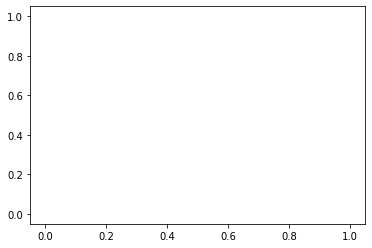

train Loss: 15.8497 Acc: 0.0041
val Loss: 13.1285 Acc: 0.0000

Epoch 1/4999
----------
train Loss: 12.0782 Acc: 0.0123
val Loss: 7.6810 Acc: 0.0588

Epoch 2/4999
----------
train Loss: 6.7292 Acc: 0.1025
val Loss: 3.5193 Acc: 0.4052

Epoch 3/4999
----------
train Loss: 3.1458 Acc: 0.4344
val Loss: 1.5856 Acc: 0.6601

Epoch 4/4999
----------
train Loss: 1.2083 Acc: 0.7336
val Loss: 0.9108 Acc: 0.8366

Epoch 5/4999
----------
train Loss: 0.7216 Acc: 0.8279
val Loss: 0.7706 Acc: 0.8693

Epoch 6/4999
----------
train Loss: 0.5097 Acc: 0.8893
val Loss: 0.7620 Acc: 0.8497

Epoch 7/4999
----------
train Loss: 0.5453 Acc: 0.8770
val Loss: 0.7669 Acc: 0.8562

Epoch 8/4999
----------
train Loss: 0.6465 Acc: 0.8566
val Loss: 0.7406 Acc: 0.8627

Epoch 9/4999
----------
train Loss: 0.5438 Acc: 0.8689
val Loss: 0.6808 Acc: 0.8889

Epoch 10/4999
----------
train Loss: 0.4413 Acc: 0.8934
val Loss: 0.6239 Acc: 0.8758

Epoch 11/4999
----------
train Loss: 0.3274 Acc: 0.8975
val Loss: 0.5900 Acc: 0.8824


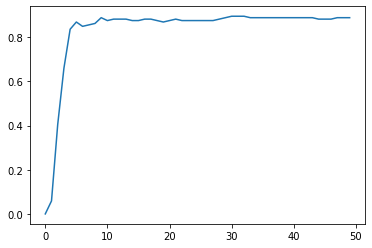

train Loss: 0.1063 Acc: 0.9590
val Loss: 0.3945 Acc: 0.8889

Epoch 51/4999
----------
train Loss: 0.1017 Acc: 0.9631
val Loss: 0.3955 Acc: 0.8889

Epoch 52/4999
----------
train Loss: 0.1462 Acc: 0.9508
val Loss: 0.3986 Acc: 0.8889

Epoch 53/4999
----------
train Loss: 0.1078 Acc: 0.9631
val Loss: 0.4019 Acc: 0.8889

Epoch 54/4999
----------
train Loss: 0.0974 Acc: 0.9713
val Loss: 0.4053 Acc: 0.8889

Epoch 55/4999
----------
train Loss: 0.0975 Acc: 0.9549
val Loss: 0.4046 Acc: 0.8889

Epoch 56/4999
----------
train Loss: 0.1100 Acc: 0.9549
val Loss: 0.4008 Acc: 0.8889

Epoch 57/4999
----------
train Loss: 0.0747 Acc: 0.9795
val Loss: 0.3973 Acc: 0.8889

Epoch 58/4999
----------
train Loss: 0.1389 Acc: 0.9385
val Loss: 0.3959 Acc: 0.8889

Epoch 59/4999
----------
train Loss: 0.1188 Acc: 0.9467
val Loss: 0.3948 Acc: 0.8889

Epoch 60/4999
----------
train Loss: 0.0750 Acc: 0.9672
val Loss: 0.3911 Acc: 0.8889

Epoch 61/4999
----------
train Loss: 0.1268 Acc: 0.9508
val Loss: 0.3885 Acc: 0

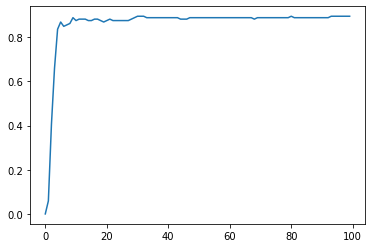

train Loss: 0.1167 Acc: 0.9467
val Loss: 0.3720 Acc: 0.8954

Epoch 101/4999
----------
train Loss: 0.0573 Acc: 0.9836
val Loss: 0.3721 Acc: 0.8954

Epoch 102/4999
----------
train Loss: 0.0707 Acc: 0.9795
val Loss: 0.3716 Acc: 0.8954

Epoch 103/4999
----------
train Loss: 0.0692 Acc: 0.9713
val Loss: 0.3728 Acc: 0.8954

Epoch 104/4999
----------
train Loss: 0.0592 Acc: 0.9877
val Loss: 0.3730 Acc: 0.8954

Epoch 105/4999
----------
train Loss: 0.0557 Acc: 0.9836
val Loss: 0.3710 Acc: 0.8954

Epoch 106/4999
----------
train Loss: 0.0981 Acc: 0.9631
val Loss: 0.3696 Acc: 0.8954

Epoch 107/4999
----------
train Loss: 0.0937 Acc: 0.9713
val Loss: 0.3680 Acc: 0.8954

Epoch 108/4999
----------
train Loss: 0.0791 Acc: 0.9631
val Loss: 0.3665 Acc: 0.8954

Epoch 109/4999
----------
train Loss: 0.0586 Acc: 0.9877
val Loss: 0.3661 Acc: 0.8954

Epoch 110/4999
----------
train Loss: 0.0971 Acc: 0.9713
val Loss: 0.3673 Acc: 0.8954

Epoch 111/4999
----------
train Loss: 0.1102 Acc: 0.9549
val Loss: 0.

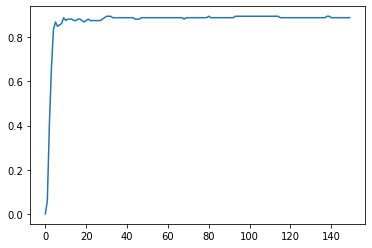

train Loss: 0.0509 Acc: 0.9877
val Loss: 0.3682 Acc: 0.8889

Epoch 151/4999
----------
train Loss: 0.0660 Acc: 0.9754
val Loss: 0.3660 Acc: 0.8889

Epoch 152/4999
----------
train Loss: 0.0432 Acc: 0.9836
val Loss: 0.3648 Acc: 0.8889

Epoch 153/4999
----------
train Loss: 0.0581 Acc: 0.9795
val Loss: 0.3643 Acc: 0.8889

Epoch 154/4999
----------
train Loss: 0.0802 Acc: 0.9713
val Loss: 0.3643 Acc: 0.8889

Epoch 155/4999
----------
train Loss: 0.0833 Acc: 0.9713
val Loss: 0.3650 Acc: 0.8889

Epoch 156/4999
----------
train Loss: 0.1127 Acc: 0.9467
val Loss: 0.3660 Acc: 0.8889

Epoch 157/4999
----------
train Loss: 0.0829 Acc: 0.9713
val Loss: 0.3667 Acc: 0.8889

Epoch 158/4999
----------
train Loss: 0.0626 Acc: 0.9836
val Loss: 0.3669 Acc: 0.8889

Epoch 159/4999
----------
train Loss: 0.0647 Acc: 0.9795
val Loss: 0.3677 Acc: 0.8889

Epoch 160/4999
----------
train Loss: 0.0480 Acc: 0.9877
val Loss: 0.3694 Acc: 0.8889

Epoch 161/4999
----------
train Loss: 0.0567 Acc: 0.9754
val Loss: 0.

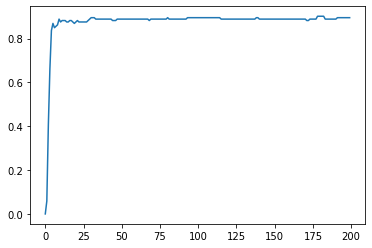

train Loss: 0.0495 Acc: 0.9836
val Loss: 0.3795 Acc: 0.8889

Epoch 201/4999
----------
train Loss: 0.0904 Acc: 0.9631
val Loss: 0.3775 Acc: 0.8954

Epoch 202/4999
----------
train Loss: 0.0769 Acc: 0.9713
val Loss: 0.3759 Acc: 0.8954

Epoch 203/4999
----------
train Loss: 0.0748 Acc: 0.9795
val Loss: 0.3743 Acc: 0.8954

Epoch 204/4999
----------
train Loss: 0.0417 Acc: 0.9877
val Loss: 0.3713 Acc: 0.8954

Epoch 205/4999
----------
train Loss: 0.0386 Acc: 0.9795
val Loss: 0.3688 Acc: 0.8954

Epoch 206/4999
----------
train Loss: 0.0713 Acc: 0.9795
val Loss: 0.3676 Acc: 0.8954

Epoch 207/4999
----------
train Loss: 0.0885 Acc: 0.9795
val Loss: 0.3676 Acc: 0.8954

Epoch 208/4999
----------
train Loss: 0.0457 Acc: 0.9877
val Loss: 0.3679 Acc: 0.8954

Epoch 209/4999
----------
train Loss: 0.1012 Acc: 0.9672
val Loss: 0.3661 Acc: 0.8954

Epoch 210/4999
----------
train Loss: 0.0564 Acc: 0.9754
val Loss: 0.3639 Acc: 0.8954

Epoch 211/4999
----------
train Loss: 0.0595 Acc: 0.9795
val Loss: 0.

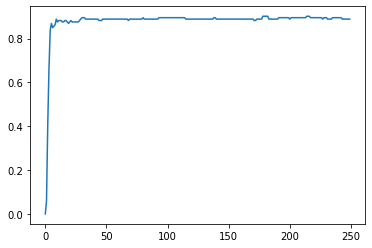

train Loss: 0.0453 Acc: 0.9836
val Loss: 0.3727 Acc: 0.8889

Epoch 251/4999
----------
train Loss: 0.0573 Acc: 0.9795
val Loss: 0.3745 Acc: 0.8889

Epoch 252/4999
----------
train Loss: 0.0622 Acc: 0.9795
val Loss: 0.3767 Acc: 0.8889

Epoch 253/4999
----------
train Loss: 0.0712 Acc: 0.9713
val Loss: 0.3782 Acc: 0.8889

Epoch 254/4999
----------
train Loss: 0.0405 Acc: 0.9877
val Loss: 0.3787 Acc: 0.8889

Epoch 255/4999
----------
train Loss: 0.0444 Acc: 0.9795
val Loss: 0.3787 Acc: 0.8889

Epoch 256/4999
----------
train Loss: 0.0398 Acc: 0.9836
val Loss: 0.3798 Acc: 0.8889

Epoch 257/4999
----------
train Loss: 0.0648 Acc: 0.9672
val Loss: 0.3809 Acc: 0.8889

Epoch 258/4999
----------
train Loss: 0.0489 Acc: 0.9713
val Loss: 0.3817 Acc: 0.8889

Epoch 259/4999
----------
train Loss: 0.0581 Acc: 0.9836
val Loss: 0.3821 Acc: 0.8889

Epoch 260/4999
----------
train Loss: 0.0653 Acc: 0.9795
val Loss: 0.3822 Acc: 0.8889

Epoch 261/4999
----------
train Loss: 0.0373 Acc: 0.9918
val Loss: 0.

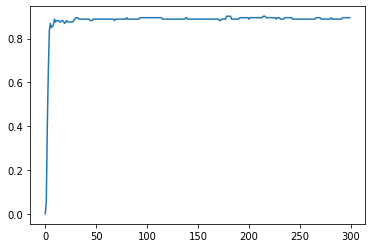

train Loss: 0.0513 Acc: 0.9836
val Loss: 0.3803 Acc: 0.8954

Epoch 301/4999
----------
train Loss: 0.0359 Acc: 0.9918
val Loss: 0.3800 Acc: 0.8954

Epoch 302/4999
----------
train Loss: 0.0399 Acc: 0.9713
val Loss: 0.3795 Acc: 0.8954

Epoch 303/4999
----------
train Loss: 0.0419 Acc: 0.9836
val Loss: 0.3796 Acc: 0.8954

Epoch 304/4999
----------
train Loss: 0.0295 Acc: 0.9836
val Loss: 0.3806 Acc: 0.8889

Epoch 305/4999
----------
train Loss: 0.0294 Acc: 0.9918
val Loss: 0.3827 Acc: 0.8889

Epoch 306/4999
----------
train Loss: 0.0248 Acc: 0.9918
val Loss: 0.3844 Acc: 0.8889

Epoch 307/4999
----------
train Loss: 0.0720 Acc: 0.9713
val Loss: 0.3837 Acc: 0.8889

Epoch 308/4999
----------
train Loss: 0.0359 Acc: 0.9877
val Loss: 0.3807 Acc: 0.8889

Epoch 309/4999
----------
train Loss: 0.0497 Acc: 0.9836
val Loss: 0.3798 Acc: 0.8889

Epoch 310/4999
----------
train Loss: 0.0654 Acc: 0.9672
val Loss: 0.3795 Acc: 0.8889

Epoch 311/4999
----------
train Loss: 0.0406 Acc: 0.9918
val Loss: 0.

Exception ignored in: <function _ConnectionBase.__del__ at 0x7f80396255f0>
Traceback (most recent call last):
  File "/home/kaizhang/.conda/envs/prune/lib/python3.7/multiprocessing/connection.py", line 132, in __del__
    self._close()
  File "/home/kaizhang/.conda/envs/prune/lib/python3.7/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor


KeyboardInterrupt: 

In [20]:
# Initialize the non-pretrained version of the model used for this run
# scratch_model,_ = initialize_model(model_name, num_classes, feature_extract=False, use_pretrained=False)

# ============= For fair comparison, should use pretrained, and only update the last few layers ===========
if model_name == "alexnet":
    scratch_model = models.alexnet(pretrained=True)
elif model_name == "vgg":
    scratch_model = models.vgg19(pretrained=True)
    
    
for param in scratch_model.features.parameters():
    param.requires_grad = False
    
for name, param in scratch_model.named_parameters():
    print("\t",name, param.requires_grad)
    
print(scratch_model)

scratch_model = scratch_model.to(device)
scratch_optimizer = optim.SGD(scratch_model.parameters(), lr=0.001, momentum=0.9)
scratch_criterion = nn.CrossEntropyLoss()
_,scratch_hist = train_model(scratch_model, dataloaders_dict, scratch_criterion, scratch_optimizer, num_epochs=num_epochs, is_inception=(model_name=="inception"))

In [21]:

if model_name == "alexnet":
    torch.save(scratch_model.state_dict()['classifier.1.weight'], 'ant_bee_Alexnet_ScratchModel_acc8889_weight.pt')
    torch.save(scratch_model.state_dict()['classifier.1.bias'], 'ant_bee_Alexnet_ScratchModel_acc8889_bias.pt')
elif model_name == "vgg":
    torch.save(scratch_model.state_dict()['classifier.weight'], 'ant_bee_VGG19_ScratchModel_acc_weight.pt')
    torch.save(scratch_model.state_dict()['classifier.bias'], 'ant_bee_VGG19_ScratchModel_acc_bias.pt')

In [22]:
scratch_model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [23]:
# Plot the training curves of validation accuracy vs. number 
#  of training epochs for the transfer learning method and
#  the model trained from scratch
ohist = []
shist = []

ohist = [h.cpu().numpy() for h in hist]
shist = [h.cpu().numpy() for h in scratch_hist]

plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),ohist,label="Pretrained")
plt.plot(range(1,num_epochs+1),shist,label="Scratch")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

NameError: name 'hist' is not defined

Final Thoughts and Where to Go Next
-----------------------------------

Try running some of the other models and see how good the accuracy gets.
Also, notice that feature extracting takes less time because in the
backward pass we do not have to calculate most of the gradients. There
are many places to go from here. You could:

-  Run this code with a harder dataset and see some more benefits of
   transfer learning
-  Using the methods described here, use transfer learning to update a
   different model, perhaps in a new domain (i.e. NLP, audio, etc.)
-  Once you are happy with a model, you can export it as an ONNX model,
   or trace it using the hybrid frontend for more speed and optimization
   opportunities.


